In [1]:
import pandas as pd
import numpy as np
import torch
from transformer_time_series_enc_dec import train_model,InformerForecaster,create_dataloaders,TrainConfig,inverse_transform,_init_weights
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
import json
from datetime import datetime
import os

def create_loss_plot(train_hist, val_hist, steps_hist, total_params=None):
    """Create a loss plot from training history"""
    df_train = pd.DataFrame({
        "Step": steps_hist,
        "Loss": train_hist,
        "Type": "Train"
    })
    if val_hist:
        val_steps, val_losses = zip(*val_hist)
        df_val = pd.DataFrame({
            "Step": val_steps,
            "Loss": val_losses,
            "Type": "Validation"
        })
        df_loss = pd.concat([df_train, df_val], ignore_index=True)
    else:
        df_loss = df_train
        
    title = "Training and Validation Loss"
    if total_params is not None:
        title += f"\nTotal Parameters: {total_params:,}"
    
    fig = px.line(df_loss, x="Step", y="Loss", color="Type", title=title)
    return fig, df_loss

def create_prediction_plots(model, val_loader, asset_idx, scaler, config, num_batches=10, save_dir=None):
    """Create prediction plots and calculate metrics for validation batches
    
    Args:
        model: The trained model
        val_loader: Validation data loader
        asset_idx: Index of the asset to predict
        scaler: Scaler used for data normalization
        config: Model configuration
        num_batches: Number of batches to visualize
        save_dir: If provided, save plots to this directory
        
    Returns:
        list: List of dictionaries containing metrics for each batch
    """
    metrics = []
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for i, (x, timestamps) in enumerate(val_loader):
            if i >= num_batches:
                break
                
            x = x.to(device)
            y_pred = model(x)
            y_true = x[:, -model.pred_len:, asset_idx]

            # Move to CPU and convert to numpy
            y_pred = y_pred.cpu().numpy()
            y_true = y_true.cpu().numpy()

            # Inverse transform to real prices
            y_pred_price = inverse_transform(y_pred.flatten(), scaler, asset_idx, config["d_input"])
            y_true_price = inverse_transform(y_true.flatten(), scaler, asset_idx, config["d_input"])

            # Create plots
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Normalised scale
            axes[0].plot(y_true.flatten(), label="Normalised True")
            axes[0].plot(y_pred.flatten(), label="Normalised Predicted")
            axes[0].set_title(f"Batch {i+1} – Normalised")
            axes[0].set_xlabel("Prediction Step")
            axes[0].set_ylabel("Scaled Value")
            axes[0].legend()

            # Real-price scale
            axes[1].plot(y_true_price, label="Real True")
            axes[1].plot(y_pred_price, label="Real Predicted")
            axes[1].set_title(f"Batch {i+1} – Real Prices")
            axes[1].set_xlabel("Prediction Step")
            axes[1].set_ylabel("Price")
            axes[1].legend()

            plt.tight_layout()
            
            # Save or show the plot
            if save_dir:
                plt.savefig(os.path.join(save_dir, f'validation_batch_{i+1}.png'))
                plt.close()
            else:
                plt.show()

            # Calculate metrics
            true = y_true.flatten()
            pred = y_pred.flatten()
            metrics.append({
                'batch': i+1,
                'true_std': float(np.std(true)),
                'pred_std': float(np.std(pred)),
                'mse': float(np.mean((true - pred) ** 2)),
                'mae': float(np.mean(np.abs(true - pred)))
            })
            
    return metrics

def save_experiment_results(config, train_hist, val_hist, steps_hist, model, val_loader_1, asset_idx, scaler, num_batches=10):
    """Save experimental results including losses, plots, and metrics"""
    # Create experiment directory with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    exp_dir = f"experiments_{timestamp}"
    os.makedirs(exp_dir, exist_ok=True)
    
    # Calculate and save total learnable parameters
    total_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Save configuration with model size
    config_with_params = config.copy()
    config_with_params['total_learnable_parameters'] = total_learnable_params
    with open(os.path.join(exp_dir, 'config.json'), 'w') as f:
        json.dump(config_with_params, f, indent=4)
    
    # Create and save loss plot and data
    fig, df_loss = create_loss_plot(train_hist, val_hist, steps_hist, total_learnable_params)
    fig.write_html(os.path.join(exp_dir, 'loss_plot.html'))
    df_loss.to_csv(os.path.join(exp_dir, 'loss_history.csv'))
    
    # Create validation plots and get metrics
    metrics = create_prediction_plots(
        model=model,
        val_loader=val_loader_1,
        asset_idx=asset_idx,
        scaler=scaler,
        config=config,
        num_batches=num_batches,
        save_dir=exp_dir
    )
    
    # Save metrics
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv(os.path.join(exp_dir, 'validation_metrics.csv'), index=False)
    
    # Save model summary information
    with open(os.path.join(exp_dir, 'model_summary.txt'), 'w') as f:
        f.write(f"Total Learnable Parameters: {total_learnable_params:,}\n")
        f.write(f"\nModel Configuration:\n")
        for key, value in config_with_params.items():
            f.write(f"{key}: {value}\n")
    
    return exp_dir

In [3]:
# -----------------------------
# Load and preprocess data
# -----------------------------
csv_path = r"D:\Quan\Quants\Neural Network\financial_attention\1h_data_20220101_20250601.csv"
closes = pd.read_csv(csv_path, index_col=0, parse_dates=True)[['SOL', 'ETH', 'BTC','ADA','XRP','LTC','TRX','LINK','DOT','DOGE']]


config = {
    "d_input": len(closes.columns),
    "d_model": 16,
    "n_heads": 4,
    "d_ff": 16,
    "enc_layers": 3,
    "dec_layers": 2,
    "dropout": 0.0,
    "enc_len": 96,
    "guiding_len": 48,
    "pred_len": 24,
    "factor": 5,
    "distill":False,
    "use_time_embedding": False 
}

train_loader, val_loader, scaler, asset_idx = create_dataloaders(closes, enc_len=config["enc_len"],
                                                                    pred_len=config["pred_len"],
                                                                    batch_size=32,val_batch_size=32, val_ratio=0.1, asset_name="SOL")
model = InformerForecaster(config, asset_index=asset_idx)

In [ ]:
# training config
tcfg = TrainConfig(learning_rate=1e-4, weight_decay=0.01, max_steps=10000, warmup_steps=200, use_amp=True, device="cuda")
model, train_hist, val_hist, steps_hist = train_model(model, train_loader, val_loader, tcfg, asset_index=asset_idx)


total_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total learnable parameters: {total_learnable_params:,}")

2025-10-17 11:57:14,075 | INFO | Using fused AdamW: True
2025-10-17 11:57:15,329 | INFO | step 0 | train loss 0.728472 | lr 0.000e+00 | tok/s 10965.2
2025-10-17 11:57:16,591 | INFO | step 0 | VALIDATION loss 1.434665


Total learnable parameters: 11,089


In [9]:
for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.numel())

enc_embedding.weight 160
enc_embedding.bias 16
dec_embedding.weight 160
dec_embedding.bias 16
month_embedding.embedding.weight 192
hour_embedding.embedding.weight 384
day_embedding.embedding.weight 496
encoder.layers.0.attn.q_proj.weight 256
encoder.layers.0.attn.q_proj.bias 16
encoder.layers.0.attn.k_proj.weight 256
encoder.layers.0.attn.k_proj.bias 16
encoder.layers.0.attn.v_proj.weight 256
encoder.layers.0.attn.v_proj.bias 16
encoder.layers.0.attn.o_proj.weight 256
encoder.layers.0.attn.o_proj.bias 16
encoder.layers.0.ff.0.weight 256
encoder.layers.0.ff.0.bias 16
encoder.layers.0.ff.2.weight 256
encoder.layers.0.ff.2.bias 16
encoder.layers.0.norm1.weight 16
encoder.layers.0.norm1.bias 16
encoder.layers.0.norm2.weight 16
encoder.layers.0.norm2.bias 16
encoder.layers.1.attn.q_proj.weight 256
encoder.layers.1.attn.q_proj.bias 16
encoder.layers.1.attn.k_proj.weight 256
encoder.layers.1.attn.k_proj.bias 16
encoder.layers.1.attn.v_proj.weight 256
encoder.layers.1.attn.v_proj.bias 16
encod

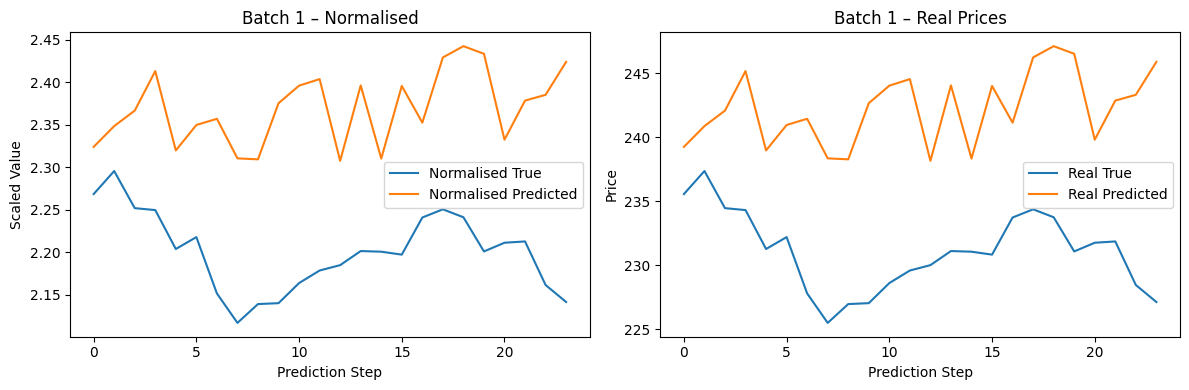

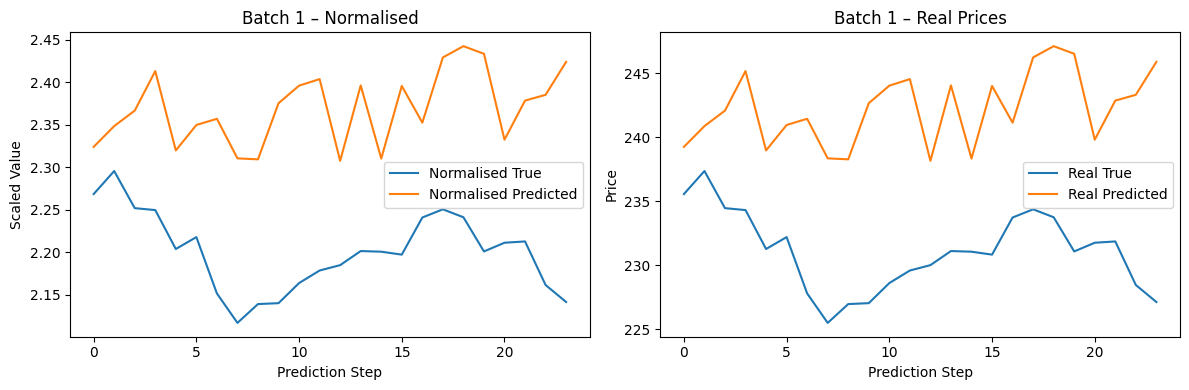

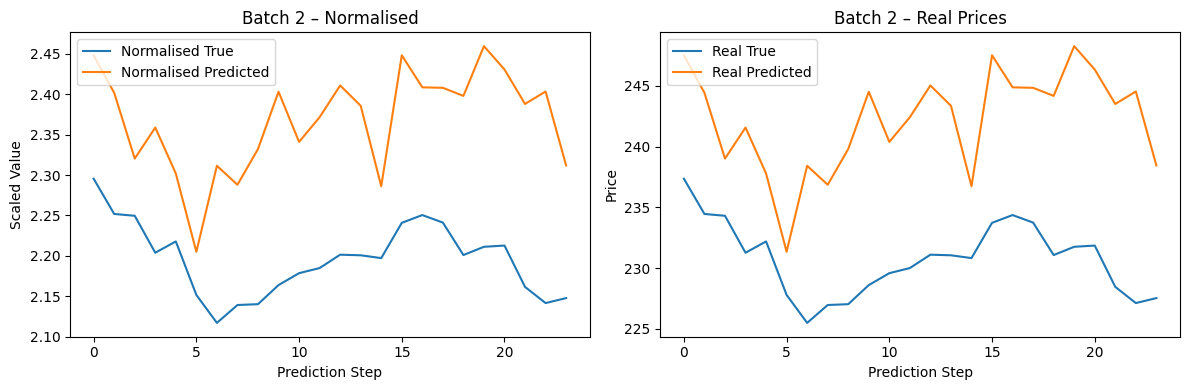

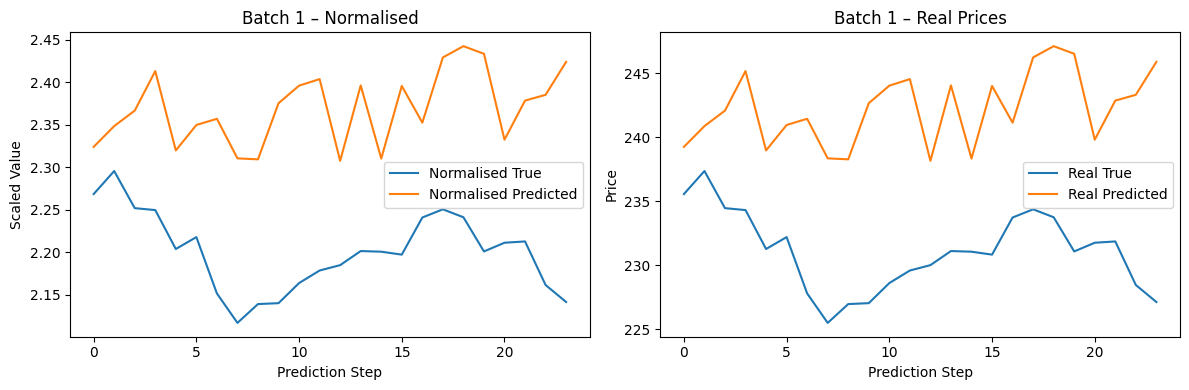

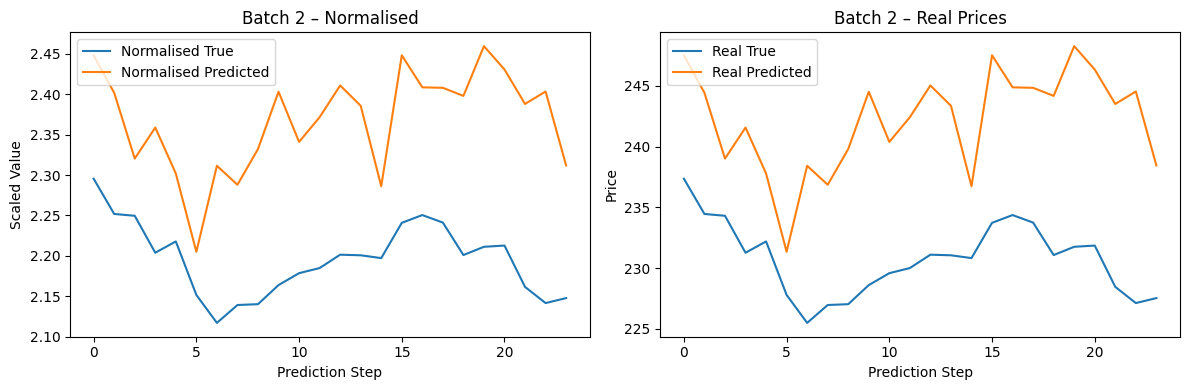

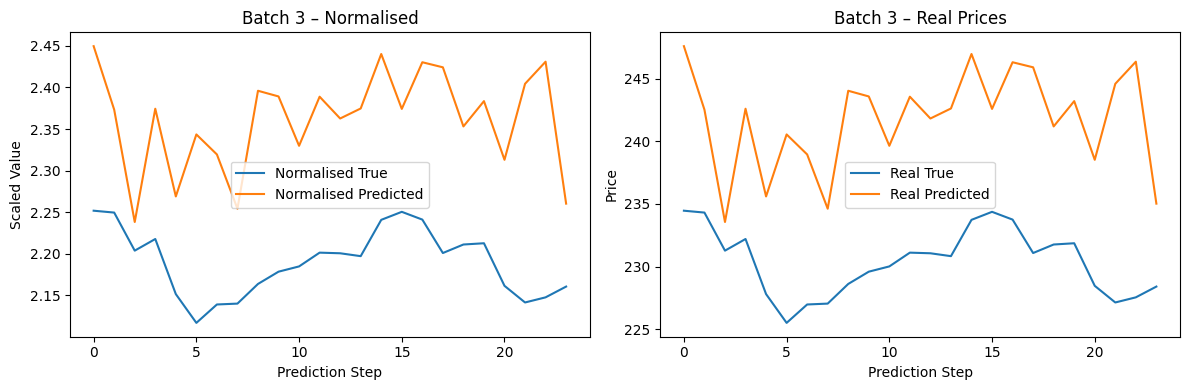

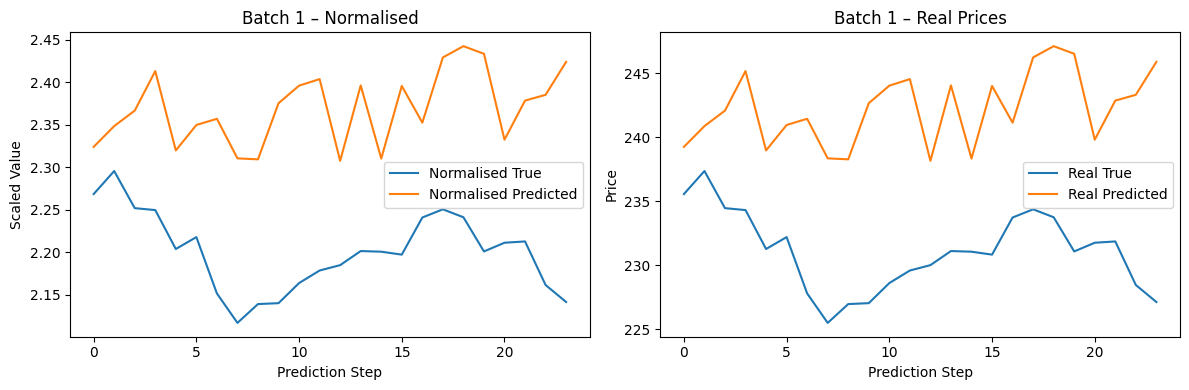

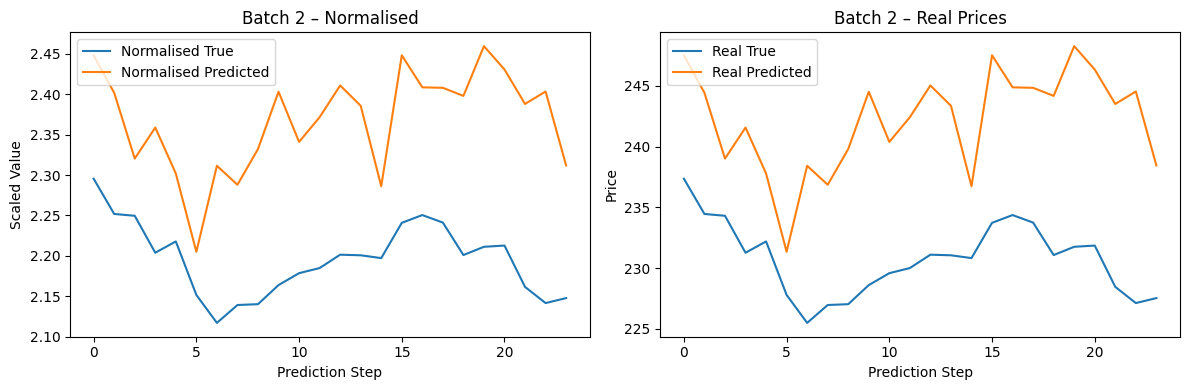

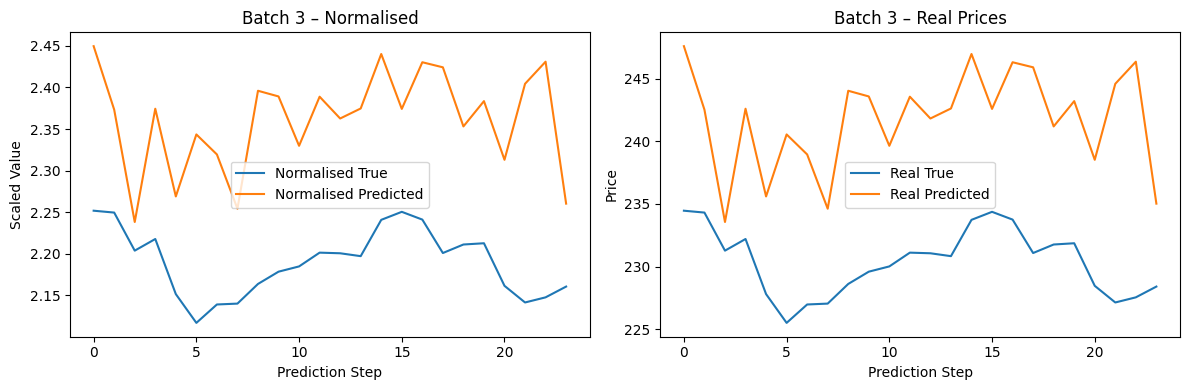

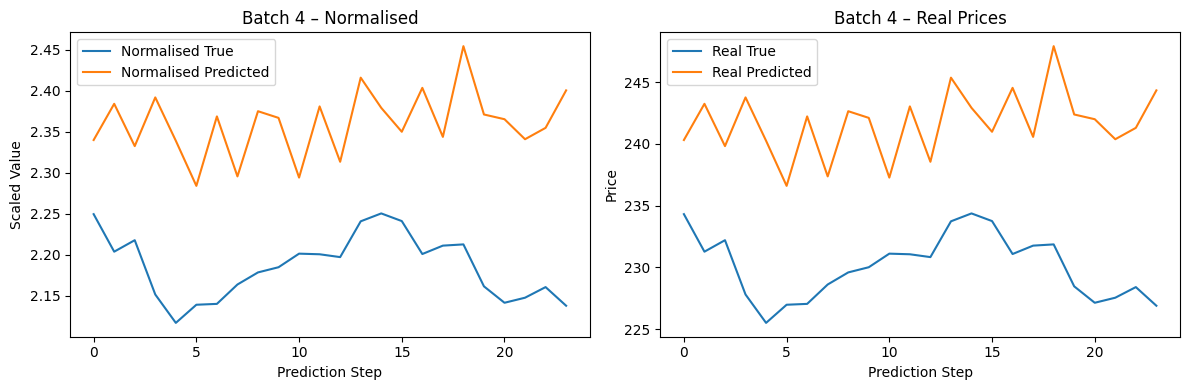

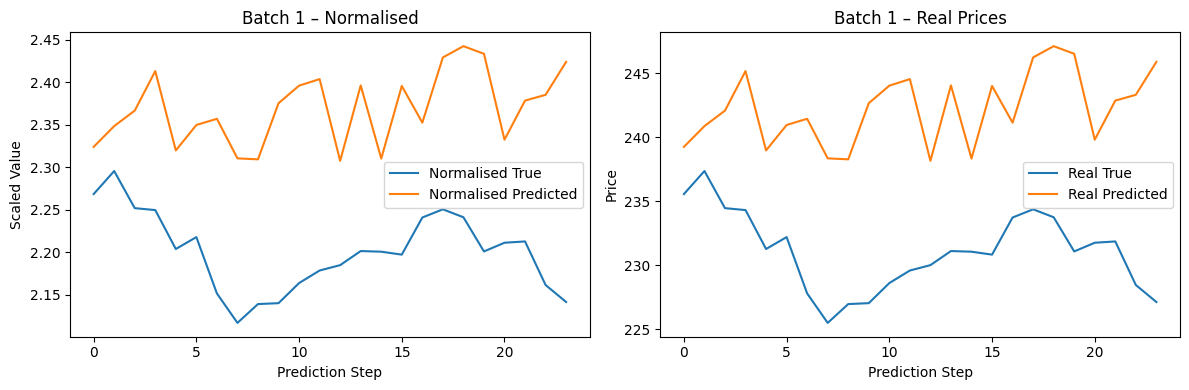

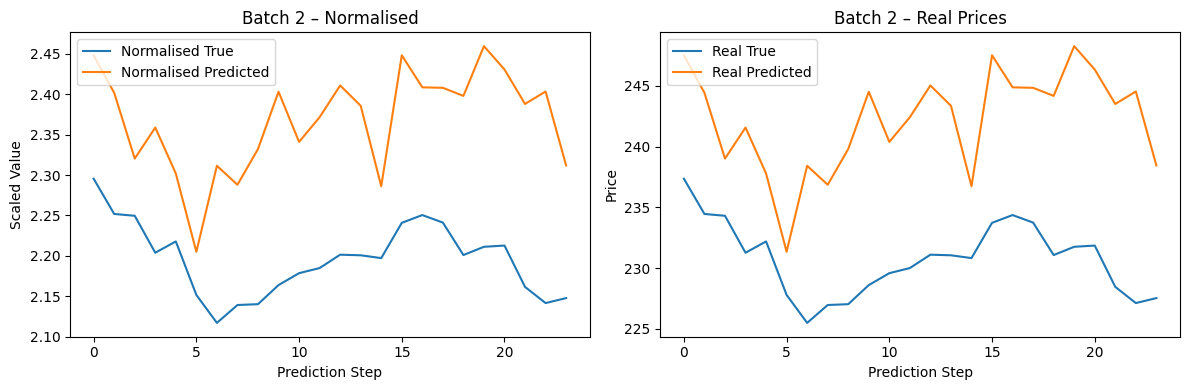

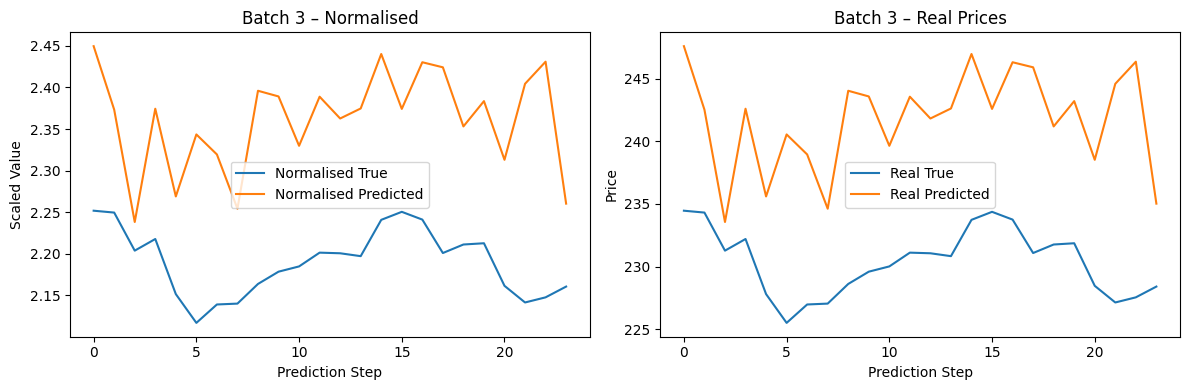

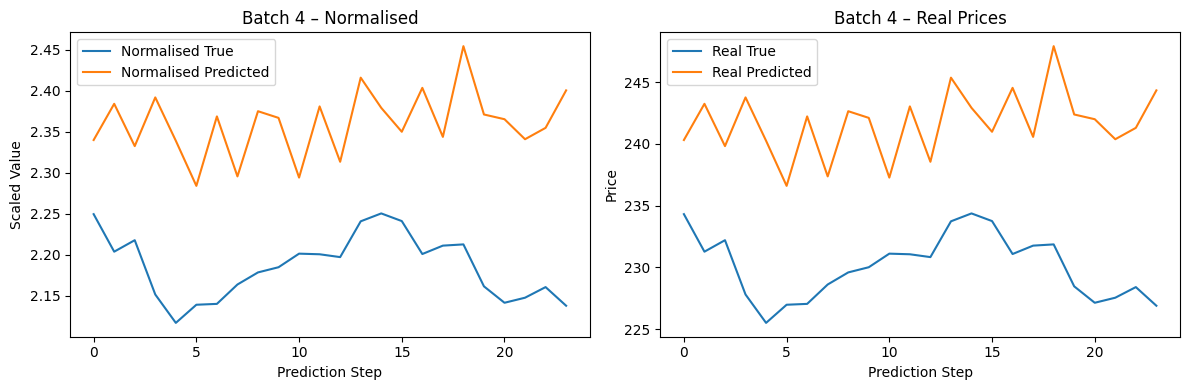

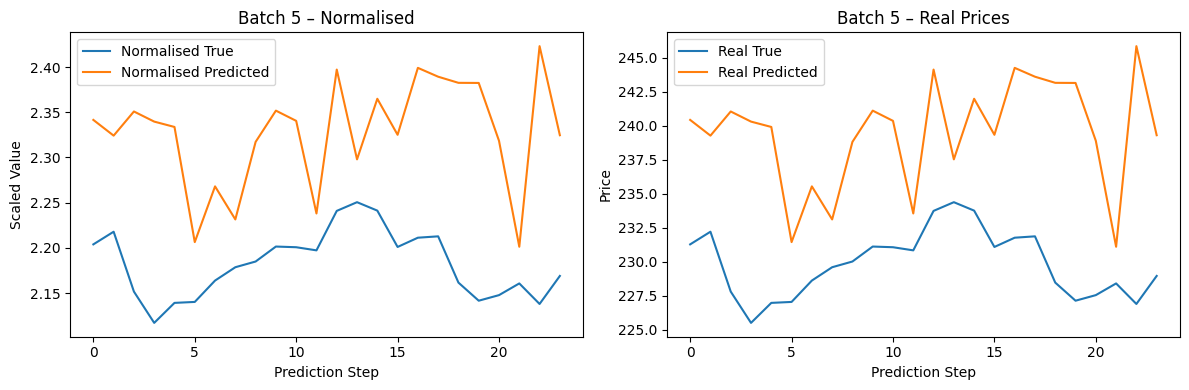

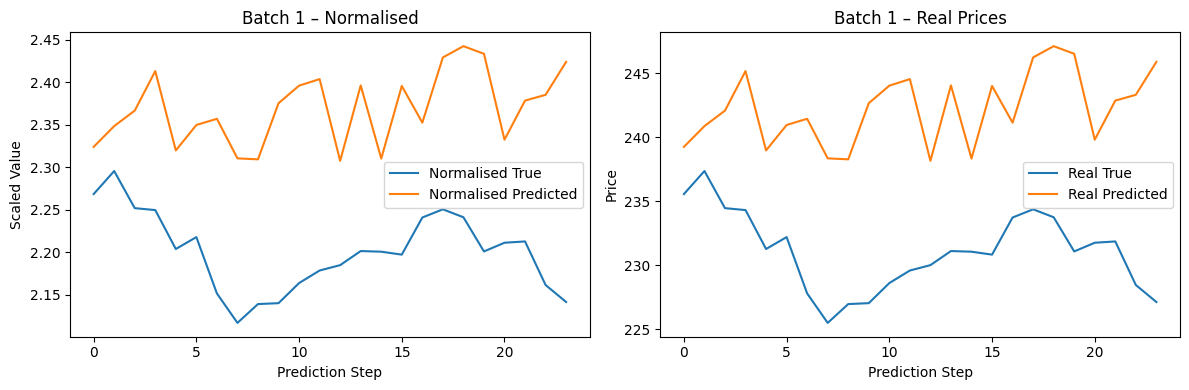

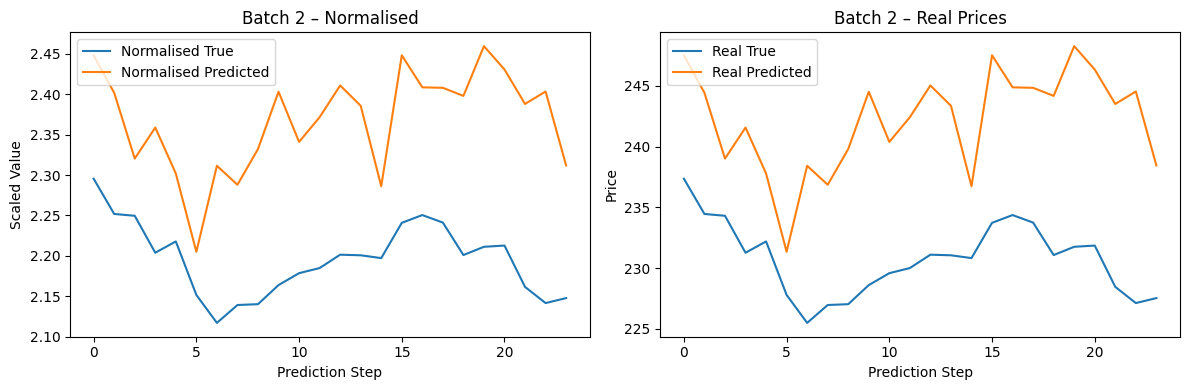

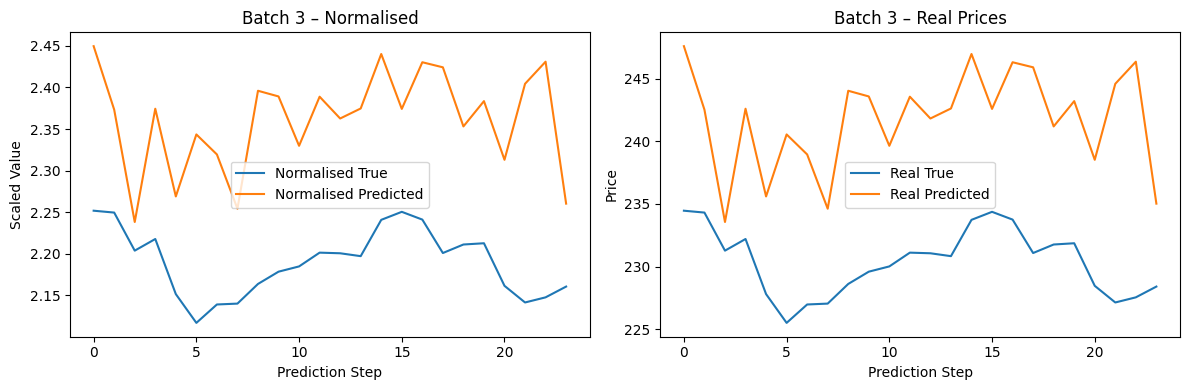

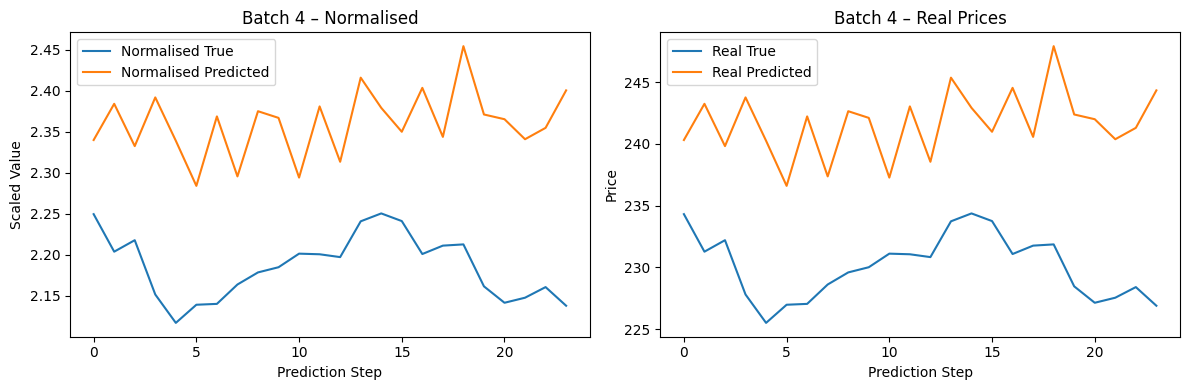

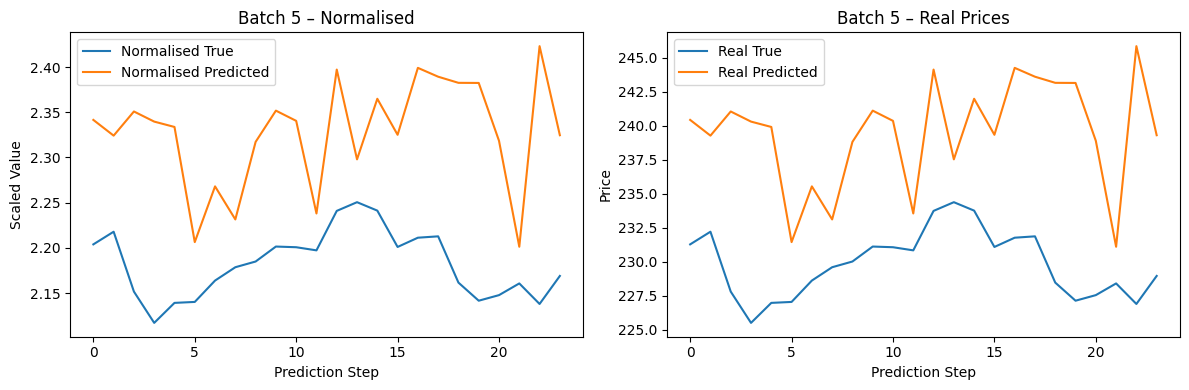

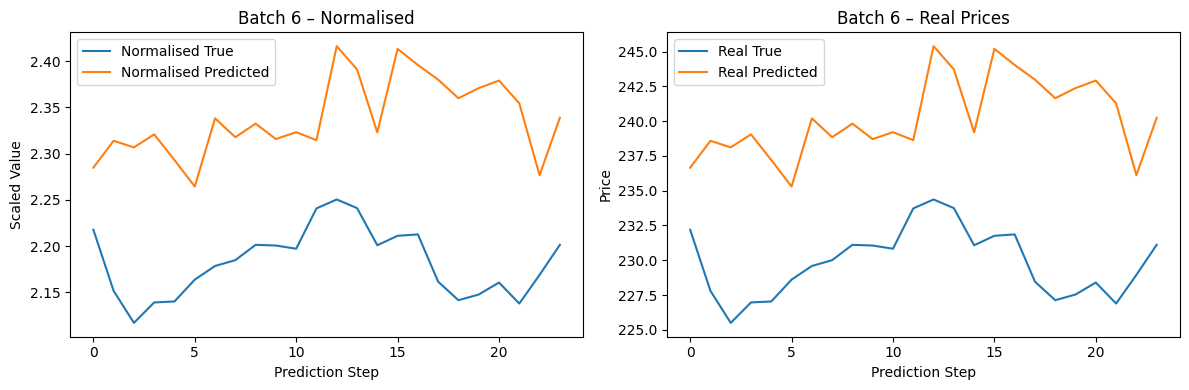

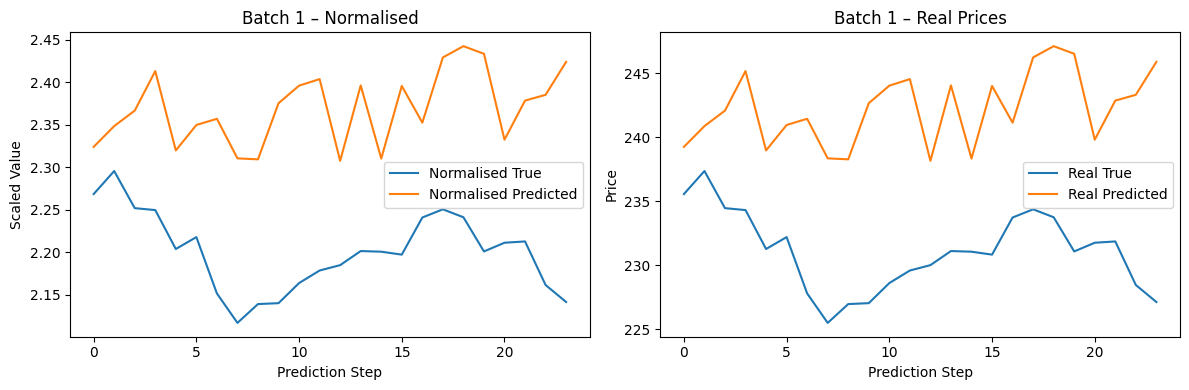

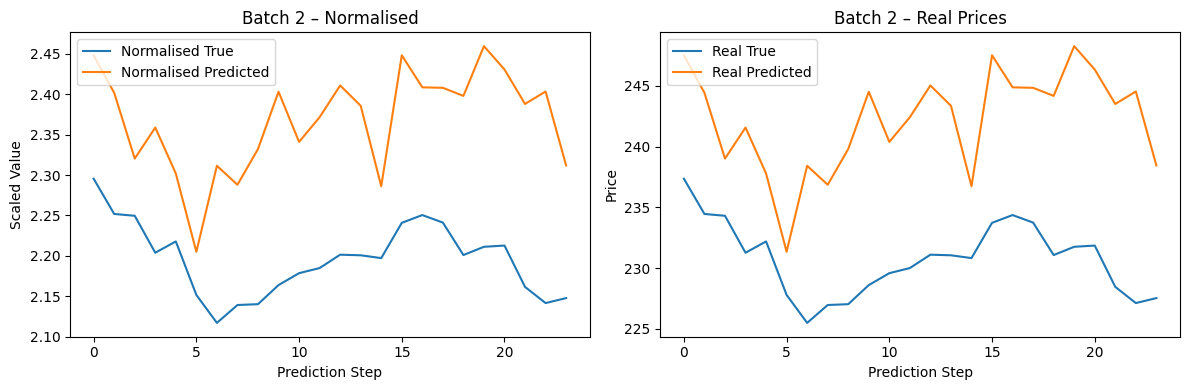

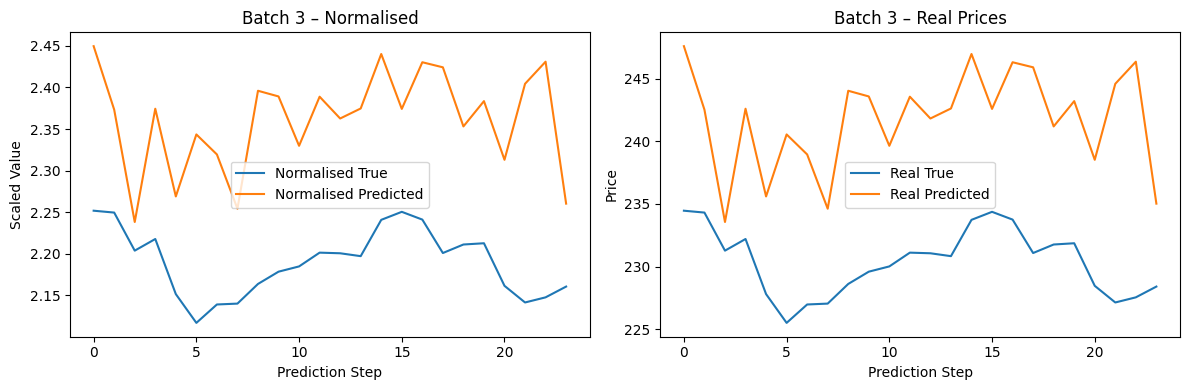

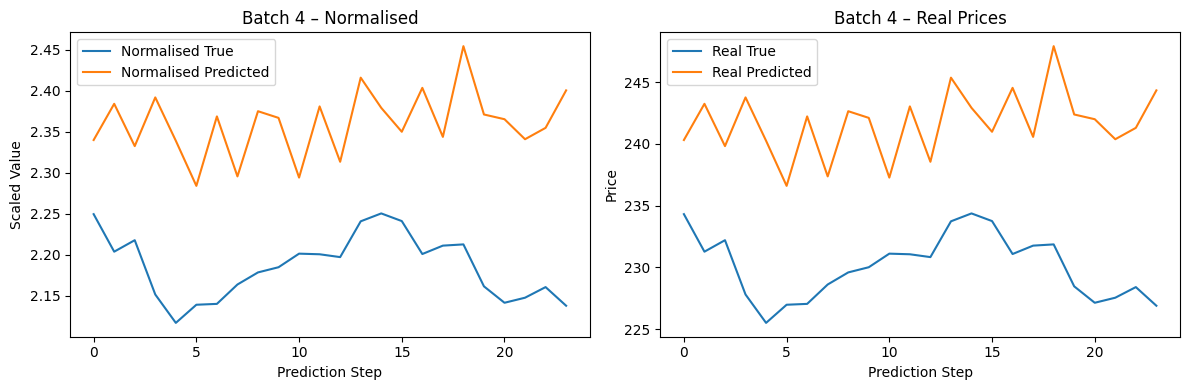

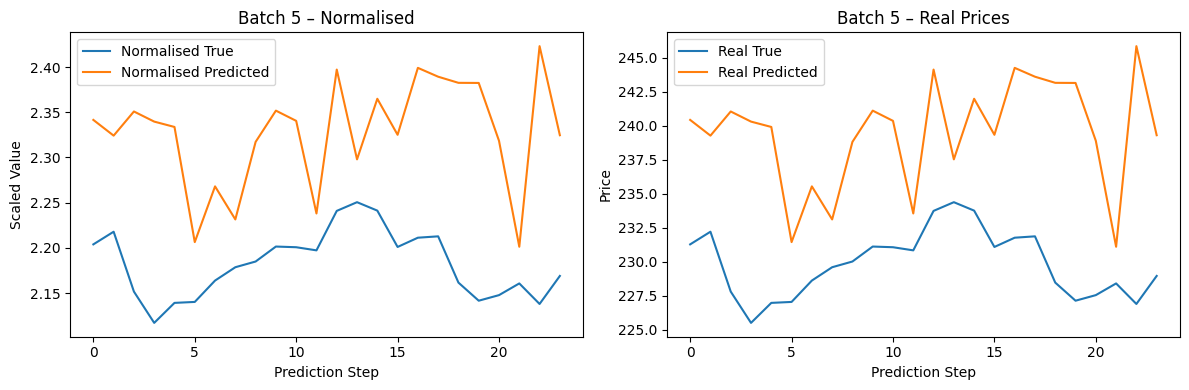

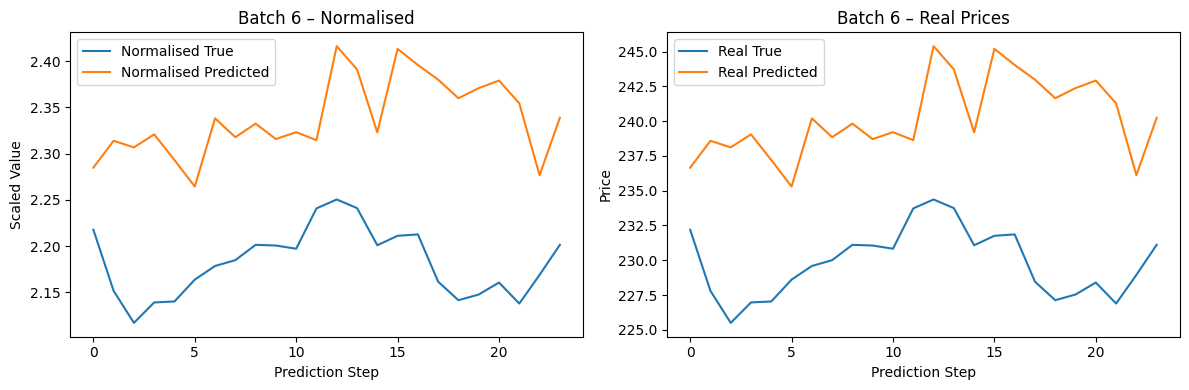

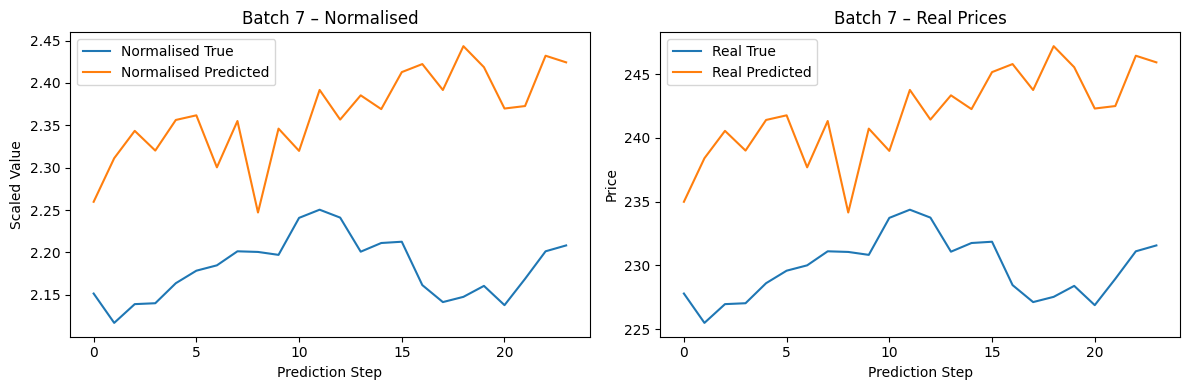

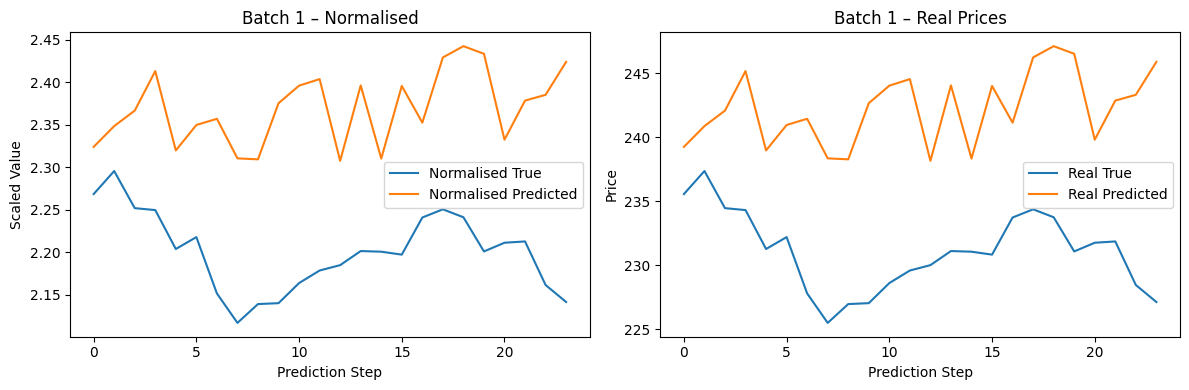

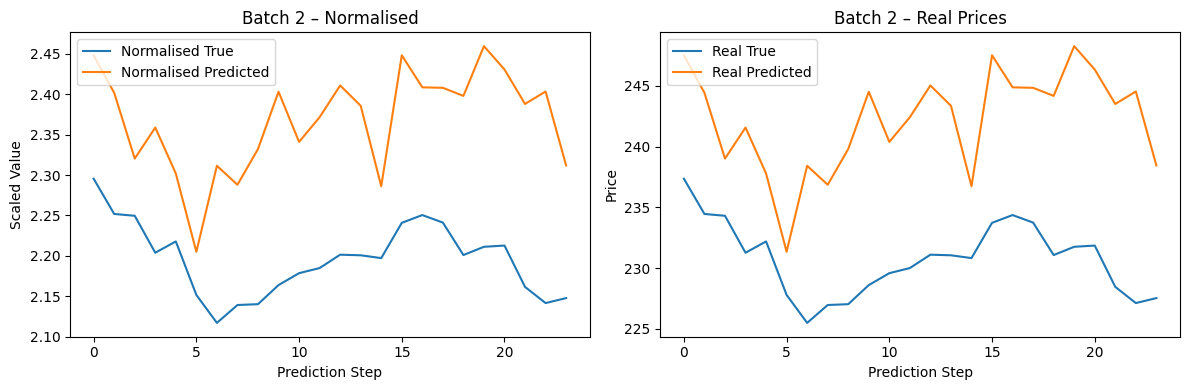

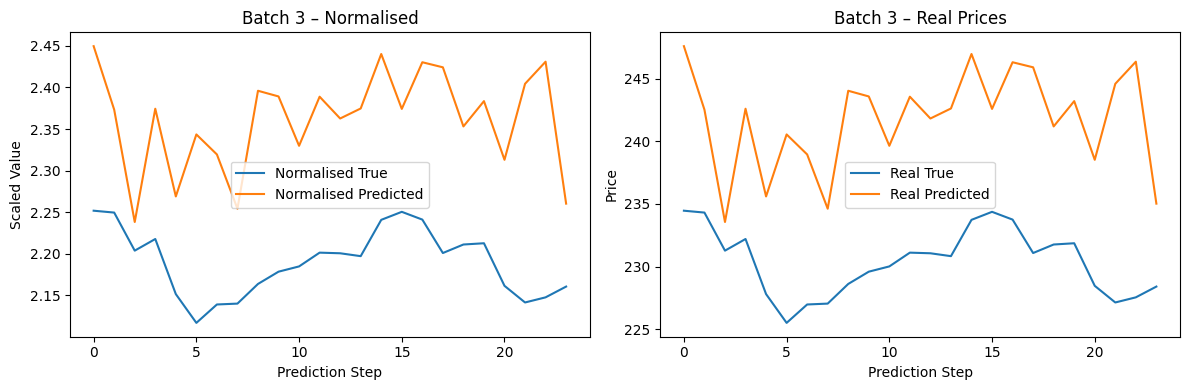

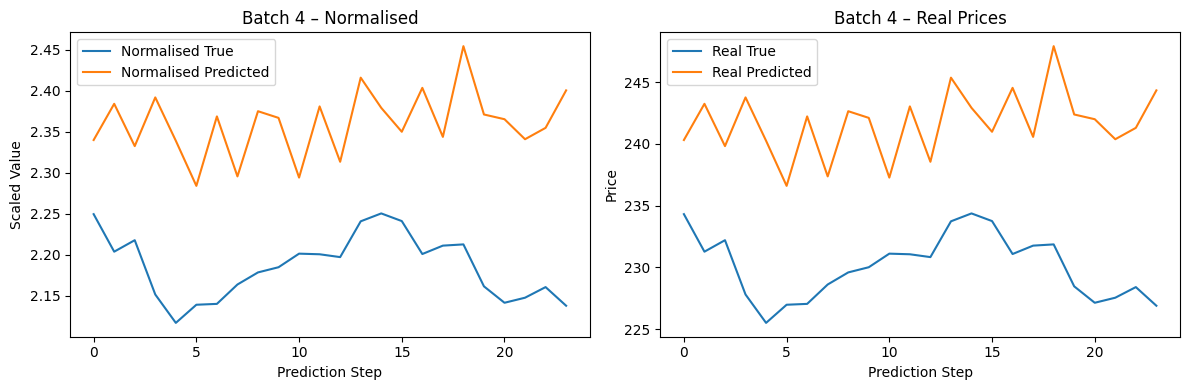

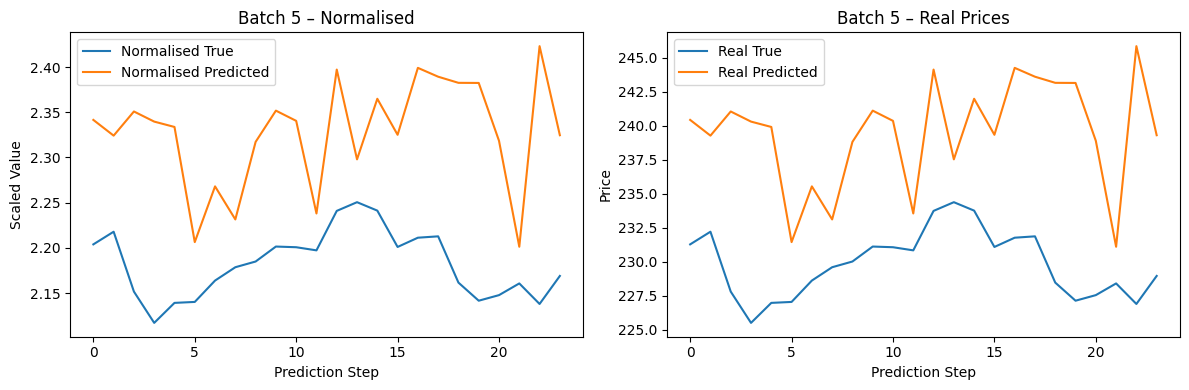

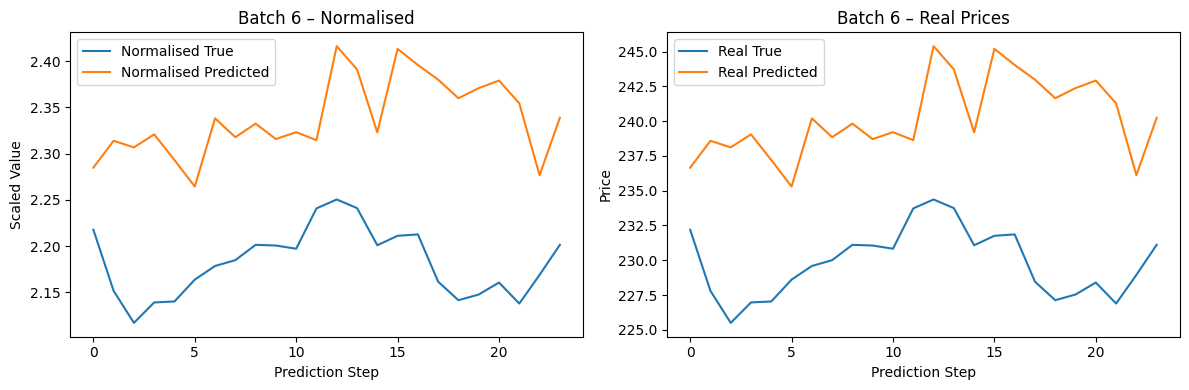

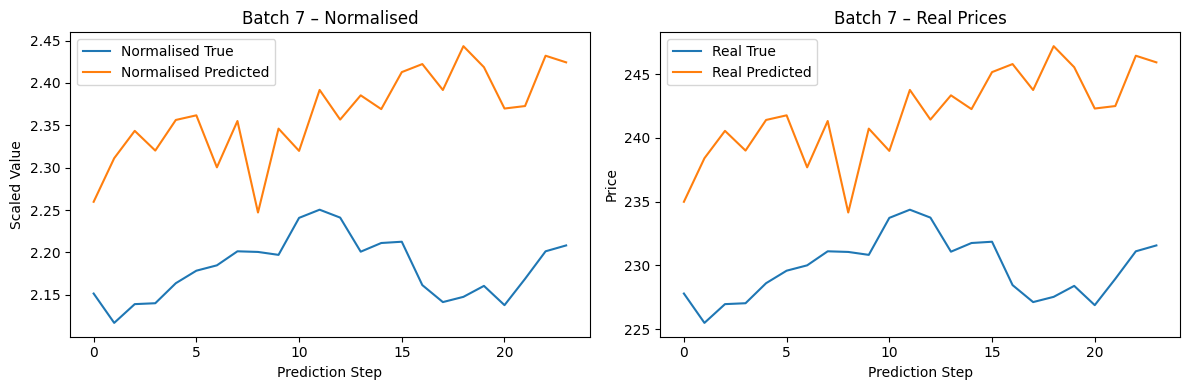

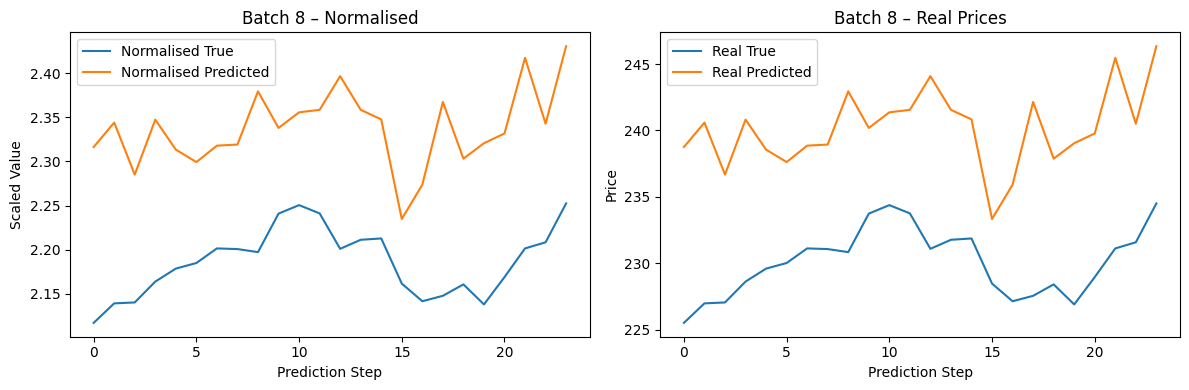

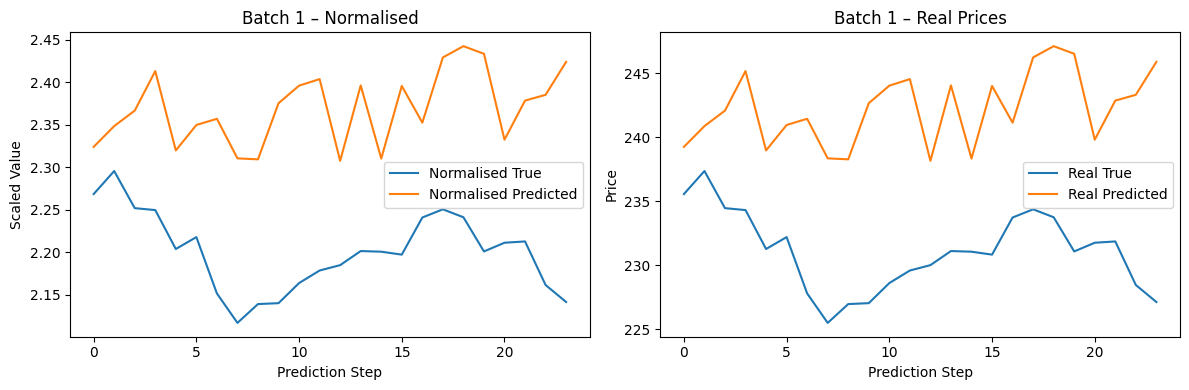

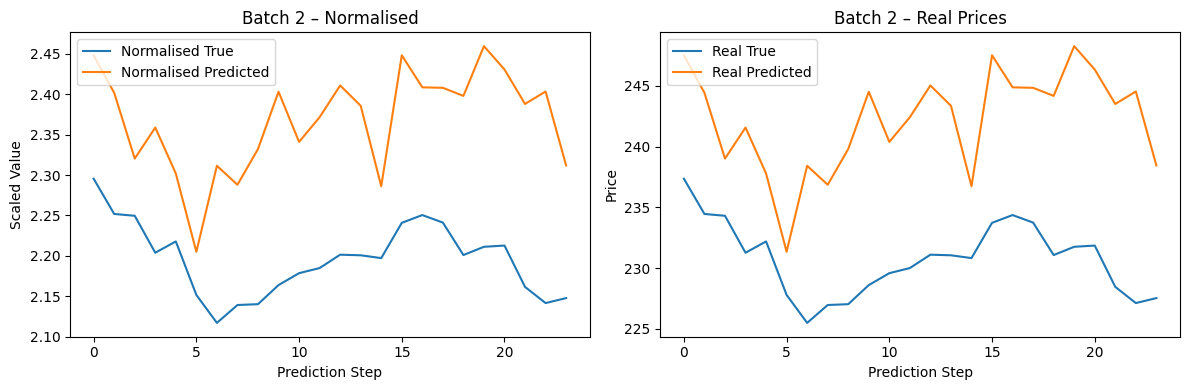

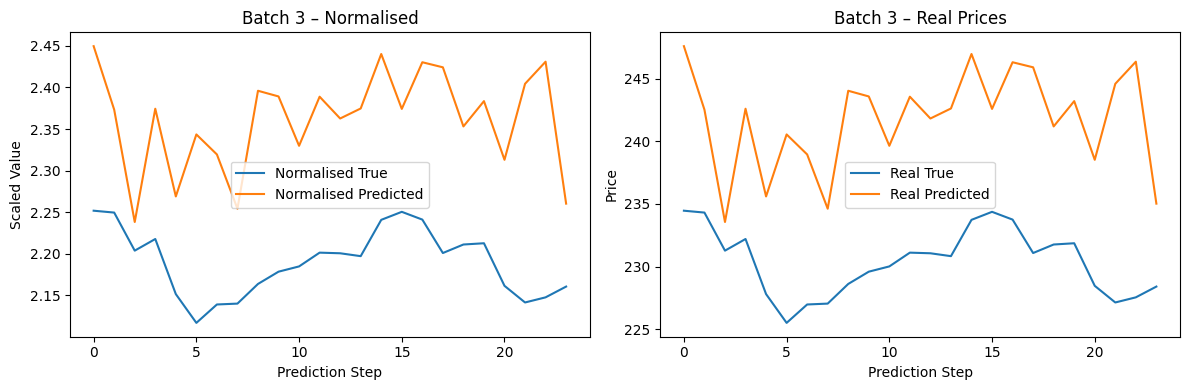

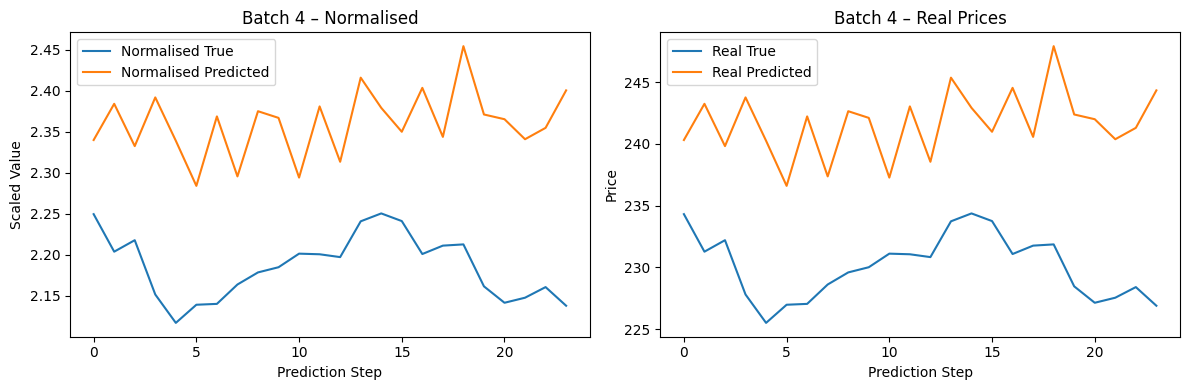

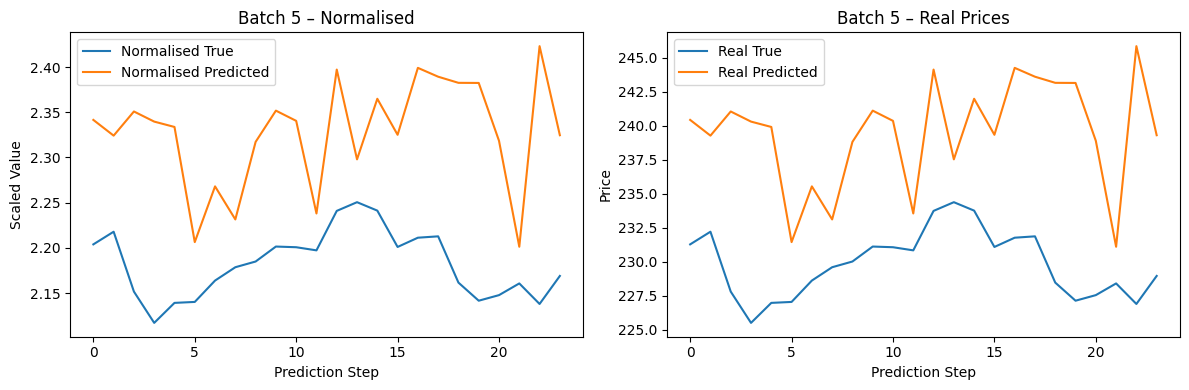

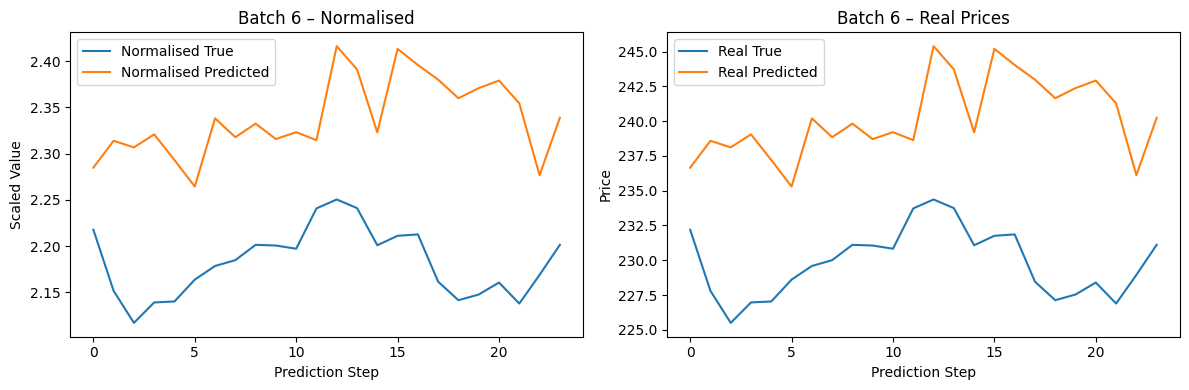

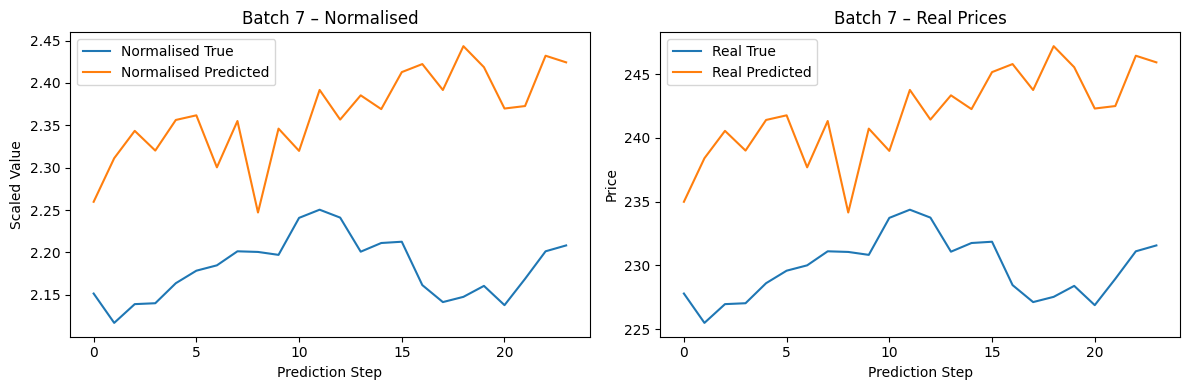

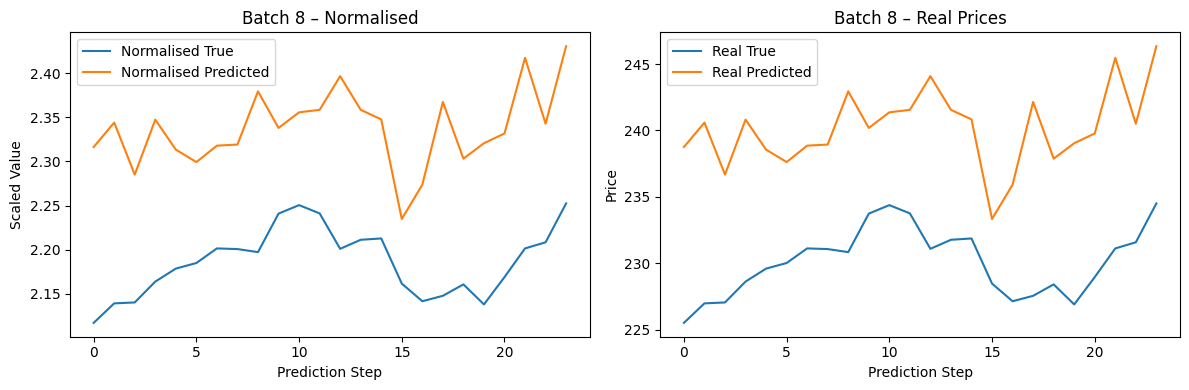

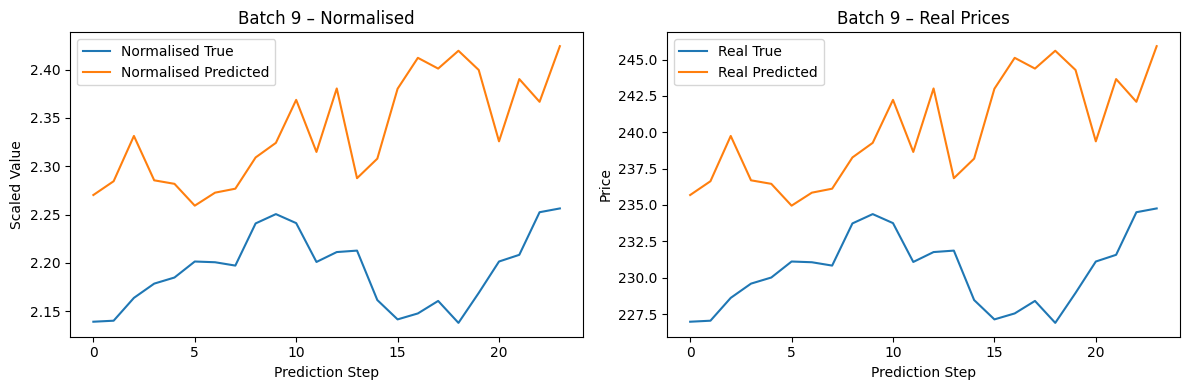

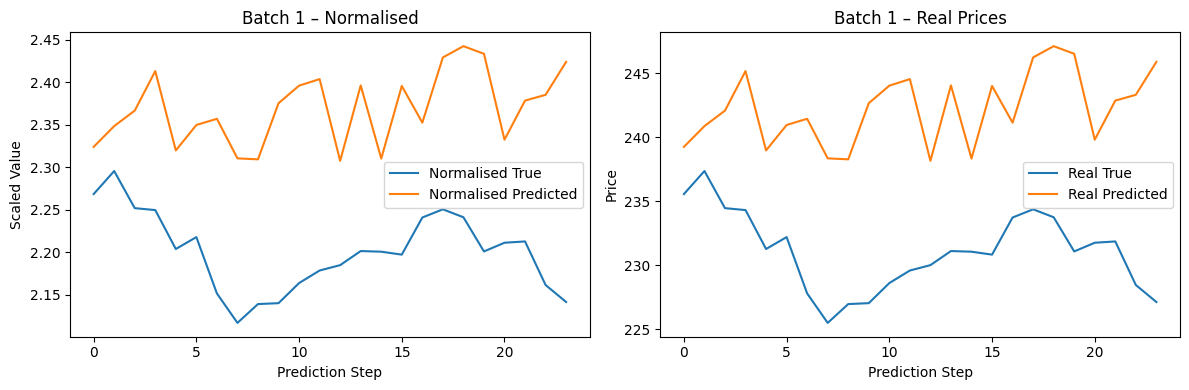

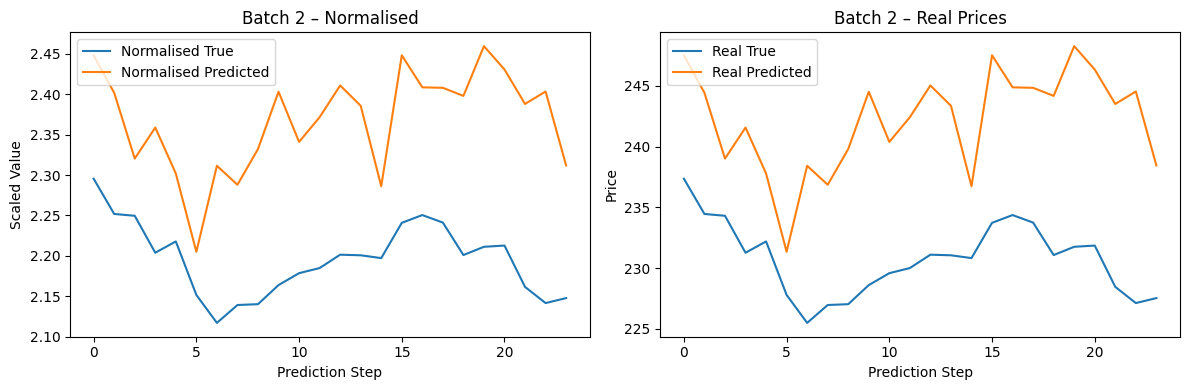

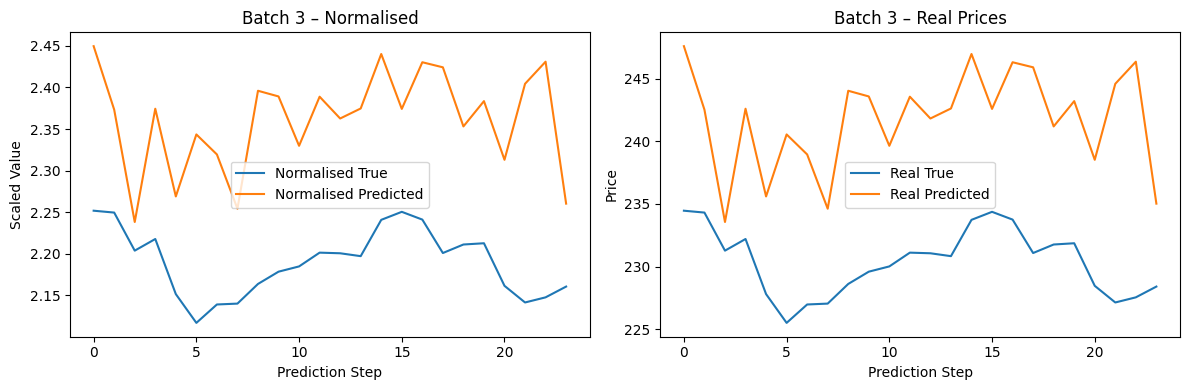

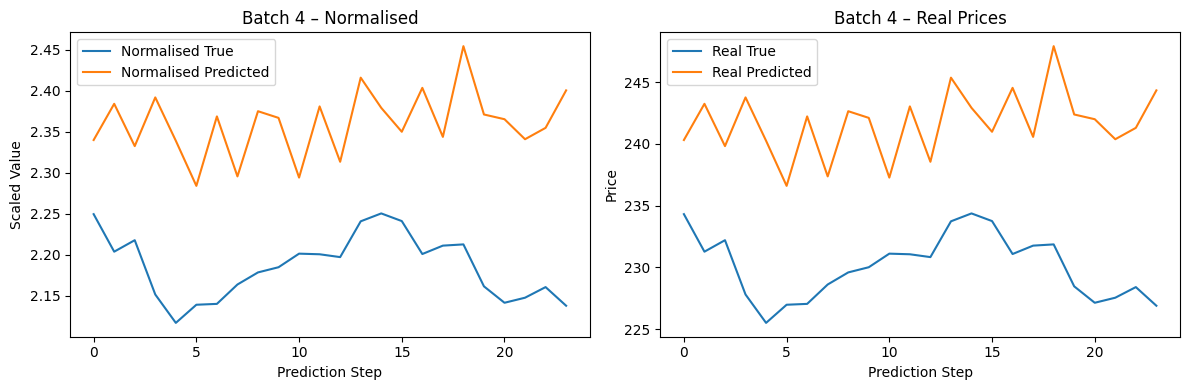

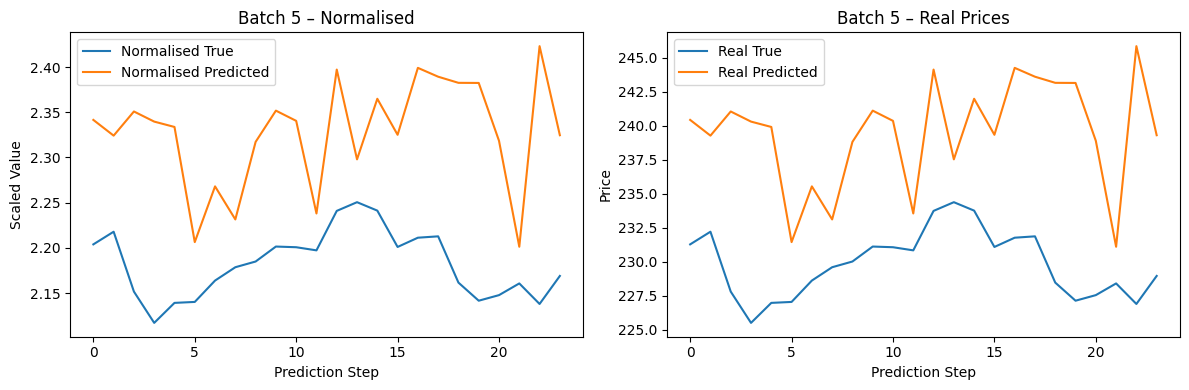

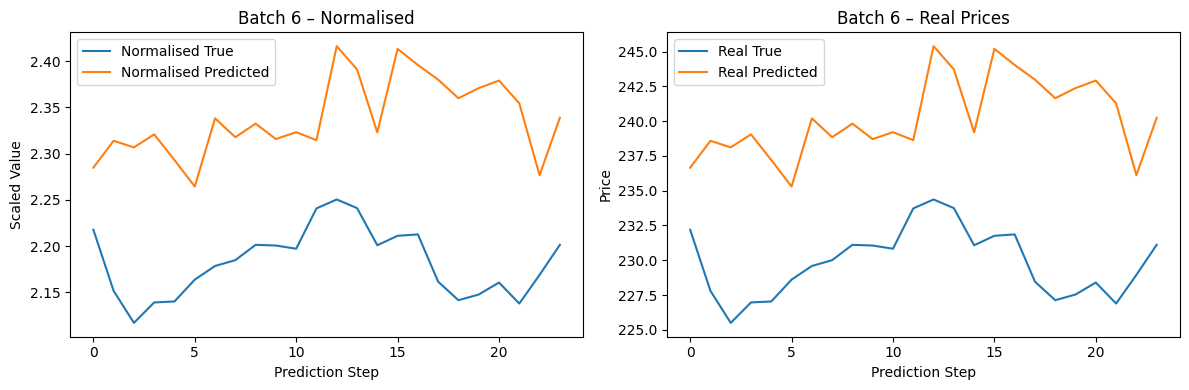

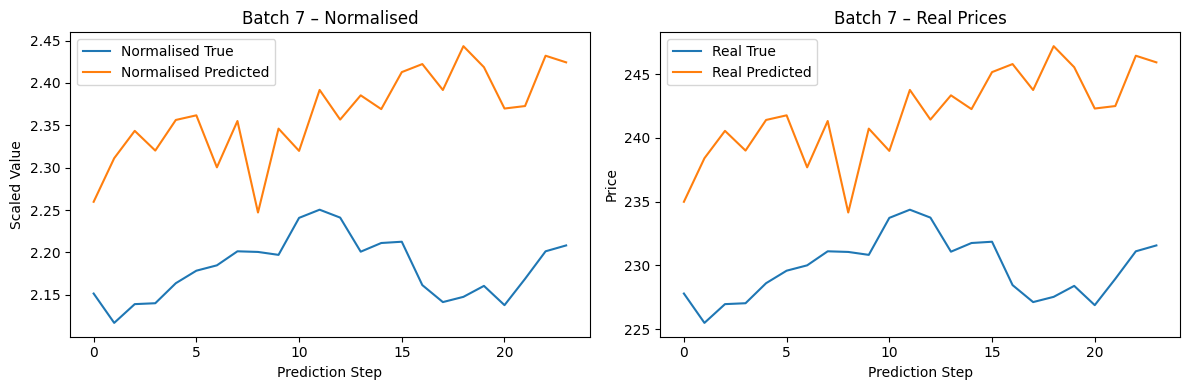

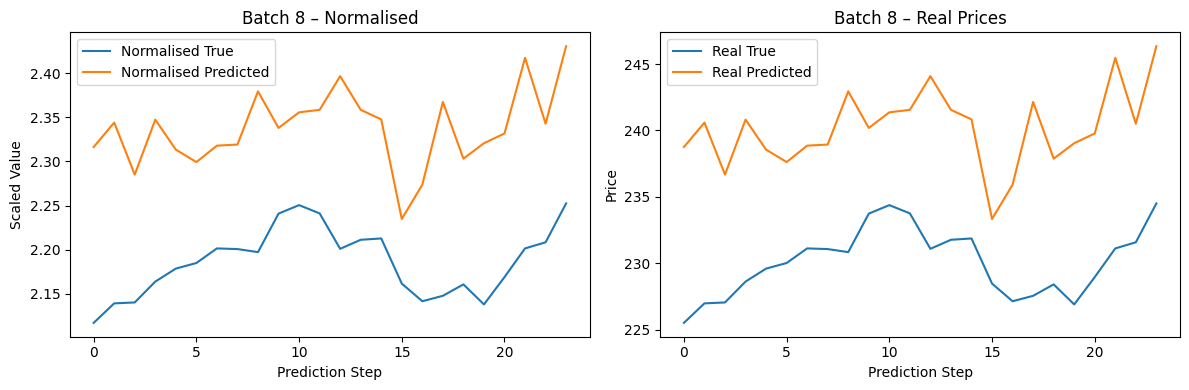

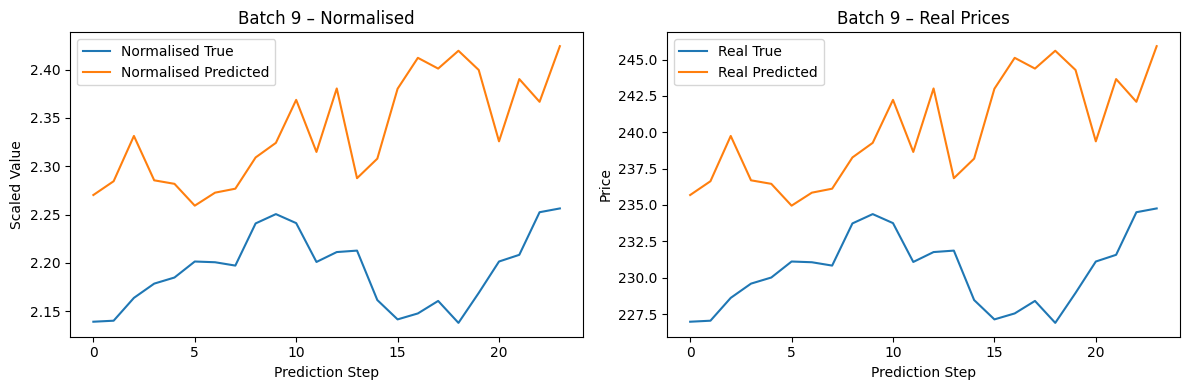

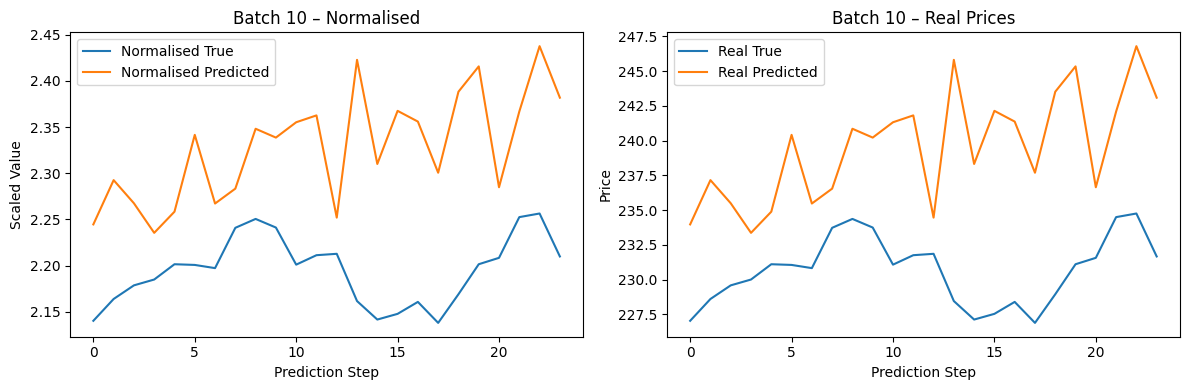


Validation Metrics Summary:
batch       5.5000
true_std    0.0387
pred_std    0.0508
mse         0.0289
mae         0.1599
dtype: float64


In [ ]:
# Visualize predictions on validation set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Create validation data loader with batch size 1 for visualization
_, val_loader_1, _, _ = create_dataloaders(closes, enc_len=config["enc_len"],
                                          pred_len=config["pred_len"],
                                          batch_size=32, val_batch_size=1, 
                                          val_ratio=0.1, asset_name="SOL")

# Create prediction plots and print metrics
metrics = create_prediction_plots(
    model=model,
    val_loader=val_loader_1,
    asset_idx=asset_idx,
    scaler=scaler,
    config=config,
    num_batches=10
)

# Print metrics summary
metrics_df = pd.DataFrame(metrics)
print("\nValidation Metrics Summary:")
print(metrics_df.mean().round(4))